### 背景说明

　Covtype数据集是一个广泛用于机器学习研究和实验的数据集，它提供了美国罗基山脉森林地区的地理和环境特征数据。这些数据主要用于预测森林覆盖类型，根据地形、土壤和其他环境特征来分类。每个样本代表了一个30米×30米的土地区块，具有54个特征，包括海拔、坡度、地形朝向、水源距离、火源距离、阳影等级以及四个野外区域和40种不同的土壤类型。  该数据集的主要目标是根据这些地理特征来预测每个区块的植被覆盖类型，覆盖类型包括了森林中的不同树种或者其他植被类型。这种预测对于森林资源管理、生态学研究以及自然资源保护都具有重要意义。因此，Covtype数据集成为了研究地理信息系统（GIS）、遥感技术和机器学习模型应用的重要基准数据集之一。

### 数据说明

　**covtype.csv**数据主要包含**海拔、地形、斜坡**等维度，**约有58万余条**。

**订单数据**

- **数据样例**

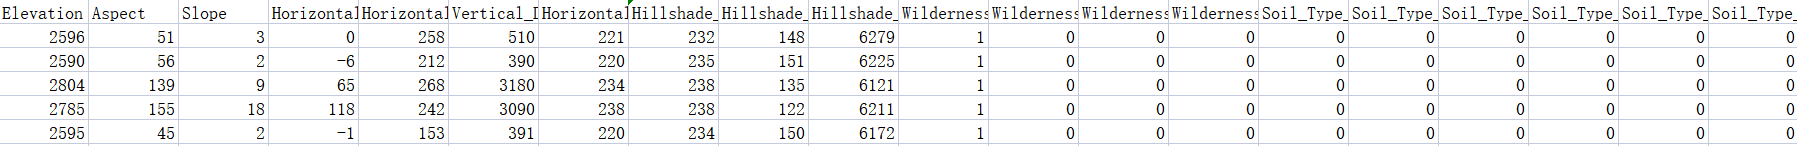

- **字段解读**

| 字段名称     | 字段说明                         |
| ------------ | -------------------------------- |
| Elevation | 海拔高度 |
| Aspect | 地形朝向，即斜坡方向的方位角度 |
| Slope | 斜坡的坡度 |
| Horizontal_Distance_To_Fire_Points | 距离最近的火源的水平距离 |
| Horizontal_Distance_To_Hydrology | 距离最近的水源的水平距离 |
| Vertical_Distance_To_Hydrology | 距离最近的水源的垂直距离 |
| Horizontal_Distance_To_Roadways | 距离最近的道路的水平距离 |
| Hillshade_9am | 早上9点的山阴指数 |
| Hillshade_Noon | 中午12点的山阴指数 |
| Hillshade_3pm | 下午3点的山阴指数 |
| Wilderness_Area_1 至 Wilderness_Area_4 | 野外区域标志 |
| Soil_Type_1 至 Soil_Type_40 | 土壤类型标志 |
| Cover_Type | 地块的覆盖类型分类 |

### 分析思路
#### 1.数据导入
　对数据进行分割，读入训练集“covtype_train.csv”与测试集“covtype_test.csv”数据，并计算训练集特征的“均值向量”与“标准差向量”。</br>
#### 2.数据处理
　数据归一化，并划分训练集、测试集、验证集。</br>
#### 3.搭建模型
　利用Pytorch框架，构建全连接神经网络模型。</br>
#### 4.训练模型
　利用训练集对模型进行训练，并保存验证集上准确率最优的预测模型。</br>
#### 5.模型测试
　训练完成后，对测试集样本点进行预测，并计算预测准确率（Accuracy）。</br>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import os

#### 1、将原始《covtype.csv》数据集划分为训练集（70%）和测试集（30%）

In [2]:
# 读取数据集
data = pd.read_csv('../dataset/cov_type.csv')
data.iloc[:, -1] = data.iloc[:, -1] - 1

# 划分特征和标签
features = data.iloc[:, :-1]
labels = data.iloc[:, -1]

# 划分数据集
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 保存数据集
if os.path.exists('../dataset/cov_type_train.csv'):
    pass
else:
    train_data.to_csv('../dataset/cov_type_train.csv', index=False)

if os.path.exists('../dataset/cov_type_test.csv'):
    pass
else:
    test_data.to_csv('../dataset/cov_type_test.csv', index=False)

# 训练集与测试集样本量
print('Train data shape:', train_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (406708, 55)
Test data shape: (174304, 55)


#### 2、使用`pandas`读入 《covtype_train.csv》 与 《covtype_test.csv》 数据。</font>

In [3]:
# 读取训练集和测试集
train_data = pd.read_csv('../dataset/cov_type_train.csv')
test_data = pd.read_csv('../dataset/cov_type_test.csv')

# 划分训练集特征和标签
train_features = train_data.iloc[:, :-1]
train_labels = train_data.iloc[:, -1]
# 划分测试集特征和标签
test_features = test_data.iloc[:, :-1]
test_labels = test_data.iloc[:, -1]
print('train_features shape:', train_features.shape)
print('train_labels shape:', train_labels.shape)
print('test_features shape:', test_features.shape)
print('test_labels shape:', test_labels.shape)

train_features shape: (406708, 54)
train_labels shape: (406708,)
test_features shape: (174304, 54)
test_labels shape: (174304,)


#### 3、利用StandardScaler获得训练集特征的均值向量 μ 和标准差向量 s。

In [4]:
# 创建StandardScaler对象
scaler = StandardScaler()


# 使用训练数据拟合scaler，该方法用于计算训练数据的均值和标准差，它不会修改原始数据
scaler.fit(train_features)

print('训练集特征均值向量 μ = ', scaler.mean_)
print('训练集特征标准差向量 s = ', np.std(scaler.var_))

训练集特征均值向量 μ =  [2.95906510e+03 1.55610822e+02 1.40975761e+01 4.63558622e+01
 2.69411034e+02 2.35023056e+03 2.12141750e+02 2.23300793e+02
 1.42526668e+02 1.98175277e+03 4.48688002e-01 5.16365550e-02
 4.35828653e-01 6.38467893e-02 5.22733755e-03 1.29085241e-02
 8.32538332e-03 2.14109386e-02 2.78086490e-03 1.12636093e-02
 1.54902289e-04 3.22098410e-04 1.97438949e-03 5.63303402e-02
 2.13642220e-02 5.18504677e-02 2.96650177e-02 1.01547056e-03
 4.91753297e-06 4.82655861e-03 5.83465287e-03 3.36113379e-03
 6.73210264e-03 1.57926571e-02 1.45558976e-03 5.77465897e-02
 9.95382437e-02 3.64733421e-02 8.18769240e-04 4.38398064e-03
 1.87358006e-03 1.63507971e-03 1.98036429e-01 5.18922667e-02
 4.42061627e-02 9.06547203e-02 7.76675158e-02 2.76365353e-03
 3.31441722e-03 2.08995151e-04 5.08964663e-04 2.68374362e-02
 2.38819989e-02 1.49566765e-02]
训练集特征标准差向量 s =  400824.6375147823


#### 4、利用 μ 和 s 对训练集和测试集特征进行归一化。

In [5]:
# 对训练集特征进行归一化，将训练数据或测试数据标准化。它接受一个二维数组作为输入，并返回标准化后的数据。标准化是通过减去均值并除以标准差来实现的
train_features = scaler.transform(train_features)

# 对测试集特征进行归一化
test_features = scaler.transform(test_features)

print('归一化后，训练集特征均值向量 μ = ', np.mean(train_features, axis=0))
print('归一化后，训练集特征标准差向量 s =', np.std(train_features, axis=0))
print('归一化后，测试集特征均值向量 μ = ', np.mean(test_features, axis=0))
print('归一化后，测试特征标准差向量 s =', np.std(test_features, axis=0))

归一化后，训练集特征均值向量 μ =  [-2.24566921e-16 -6.96726996e-17 -3.51508204e-17  6.46411706e-18
  9.76780500e-17 -4.23487021e-17 -2.31939508e-16  1.13995578e-16
 -1.87389512e-16  3.21284089e-17 -1.32077635e-17 -4.81314662e-17
 -1.74007043e-17  1.27054841e-17  1.46883957e-17  4.22526138e-17
 -2.54721153e-17 -1.91477630e-17 -5.49449950e-17 -2.68260858e-17
  5.41588186e-18  9.71364618e-18  1.08667049e-17  3.32639970e-17
 -2.27991156e-17  7.67657578e-17  3.81907024e-17 -7.92291105e-18
 -2.14014687e-19  2.75511152e-17  3.31242323e-17 -2.94029973e-17
  9.32929327e-18 -2.47907625e-17 -2.04405864e-17 -9.45158738e-18
 -3.78412907e-17 -1.13384107e-17 -1.73308220e-17  4.33270549e-18
  2.90011738e-18 -2.12966451e-17 -2.68872329e-17 -5.38792892e-17
  3.57972321e-17  4.91622308e-17 -1.70512926e-17 -3.76665848e-17
  1.92176453e-18  1.67717632e-17 -6.49905824e-18 -8.31425219e-17
 -4.55720253e-17 -6.65279940e-17]
归一化后，训练集特征标准差向量 s = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1

#### 5、保留 10% 的训练集作为验证集。

In [6]:
train_features, valid_features, train_labels, valid_labels = train_test_split(train_features, train_labels,
test_size = 0.1, random_state = 42)

print('训练集特征矩阵维度:', train_features.shape, '测试集标签矩阵维度:', train_labels.shape)
print('验证集特征矩阵维度:', valid_features.shape, '验证集标签矩阵维度:', valid_labels.shape)
print('测试集特征矩阵维度:', test_features.shape, '测试集标签矩阵维度:', test_labels.shape)

训练集特征矩阵维度: (366037, 54) 测试集标签矩阵维度: (366037,)
验证集特征矩阵维度: (40671, 54) 验证集标签矩阵维度: (40671,)
测试集特征矩阵维度: (174304, 54) 测试集标签矩阵维度: (174304,)


#### 6、定义分类预测神经网络模型。

In [7]:
# 定义神经网络模型
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# 初始化模型
net = Net(input_size=54, hidden_size=50, num_classes=7)

# 打印模型结构信息及参数量
print('模型结构信息：', net)
print('模型参数量：', sum(p.numel() for p in net.parameters()))

模型结构信息： Net(
  (fc1): Linear(in_features=54, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (relu): ReLU()
)
模型参数量： 3107


#### 7、定义损失函数和优化器。

In [8]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

#### 8、将所有数据转换为Tensor。

In [9]:
from torch.utils.data import TensorDataset

# 将数据转换为PyTorch张量
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.int64)

valid_features_tensor = torch.tensor(valid_features, dtype=torch.float32)
valid_labels_tensor = torch.tensor(valid_labels.values, dtype=torch.int64)

# 创建数据加载器
train_data = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

#### 9、训练模型，并保存验证集上准确率最优的预测模型。

In [10]:
best_model = None
best_acc = 0

# 初始化准确率列表
train_acc_list = []
valid_acc_list = []

# 训练模型
for epoch in range(20):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # 遍历训练集数据加载器
    for i, data in enumerate(train_loader, 0):
        # 获得输入数据
        inputs, labels = data

        # 梯度清零
        optimizer.zero_grad()

        # 前向传播 + 反向传播 + 优化
        outputs = net(inputs)  # 执行前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 根据梯度更新模型参数

        running_loss += loss.item()

        # 计算训练集准确率
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    train_acc_list.append(train_acc)

    print('============== Epoch %d ==============' % (epoch + 1))
    print('Train Accuracy: %.2f %%' % train_acc)

    # 使用验证集评估模型
    with torch.no_grad():
        valid_outputs = net(valid_features_tensor)
        _, predicted = torch.max(valid_outputs, 1)

        # 计算验证集准确率
        correct_valid = (predicted == valid_labels_tensor).sum().item()
        valid_acc = 100 * correct_valid / valid_labels_tensor.size(0)
        print('Validation Accuracy: %d %%' % valid_acc)
        valid_acc_list.append(valid_acc)

        # 保存最佳验证集上Accuracy最高的模型
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model = net

print('Finished Training')


============== Epoch 1 ==============
Train Accuracy: 74.91 %
Validation Accuracy: 76 %
============== Epoch 2 ==============
Train Accuracy: 77.45 %
Validation Accuracy: 77 %
============== Epoch 3 ==============
Train Accuracy: 78.51 %
Validation Accuracy: 77 %
============== Epoch 4 ==============
Train Accuracy: 79.16 %
Validation Accuracy: 78 %
============== Epoch 5 ==============
Train Accuracy: 79.56 %
Validation Accuracy: 79 %
============== Epoch 6 ==============
Train Accuracy: 79.74 %
Validation Accuracy: 80 %
============== Epoch 7 ==============
Train Accuracy: 79.99 %
Validation Accuracy: 79 %
============== Epoch 8 ==============
Train Accuracy: 80.23 %
Validation Accuracy: 80 %
============== Epoch 9 ==============
Train Accuracy: 80.32 %
Validation Accuracy: 80 %
============== Epoch 10 ==============
Train Accuracy: 80.48 %
Validation Accuracy: 79 %
============== Epoch 11 ==============
Train Accuracy: 80.56 %
Validation Accuracy: 81 %
============== Epoch 12 ======

#### 10、绘制训练集和验证集的准确率变化曲线。

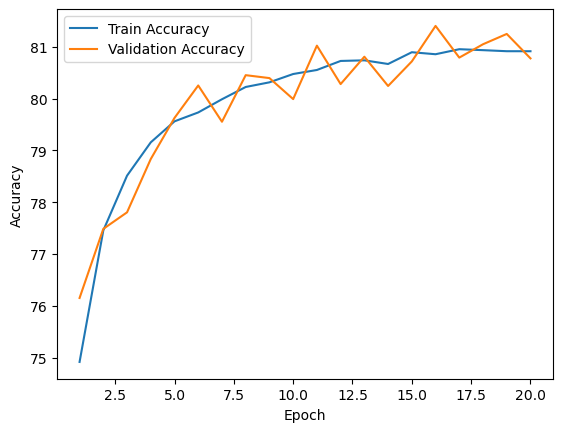

In [11]:
epochs = list(range(1, len(train_acc_list) + 1))

plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, valid_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 11、对测试集样本点进行预测，计算预测准确率。

In [12]:
with torch.no_grad():
    test_outputs = best_model(torch.tensor(test_features, dtype=torch.float32))
    _, predicted = torch.max(test_outputs, 1)
    correct_test = (predicted == torch.tensor(test_labels.values, dtype=torch.int64)).sum().item()
    print('Test Accuracy: %d %%' % (100 * correct_test / test_labels.size))

Test Accuracy: 80 %
